In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib as pyplot
pd.plotting.register_matplotlib_converters()

In [2]:
df = pd.read_json("../data/scifi_fantasy.json.gz", lines=True, convert_dates=True)

In [3]:
df.describe()

,text_reviews_count,average_rating,book_id,ratings_count,work_id
count,16428.000000,16428.000000,1.642800e+04,1.642800e+04,1.642800e+04
mean,850.823229,4.008191,8.611519e+06,1.834899e+04,1.184865e+07
std,3100.547710,0.264798,8.825927e+06,1.019416e+05,1.377765e+07
min,2.000000,2.570000,1.000000e+00,1.000000e+03,4.230000e+02
25%,109.000000,3.840000,3.175178e+05,1.724000e+03,1.369444e+06
50%,243.000000,4.010000,6.624640e+06,3.497000e+03,5.329808e+06
75%,584.000000,4.200000,1.572779e+07,9.346750e+03,1.852233e+07
max,142645.000000,4.820000,3.638104e+07,4.899965e+06,5.799794e+07


In [5]:
df.columns

Index(['isbn', 'text_reviews_count', 'series', 'country_code', 'language_code',
       'popular_shelves', 'asin', 'is_ebook', 'average_rating', 'kindle_asin',
       'similar_books', 'description', 'format', 'link', 'authors',
       'publisher', 'num_pages', 'publication_day', 'isbn13',
       'publication_month', 'edition_information', 'publication_year', 'url',
       'image_url', 'book_id', 'ratings_count', 'work_id', 'title',
       'title_without_series'],
      dtype='object')

In [13]:
awards = pd.read_json("../data/awards.jsonl", lines=True)
awards["year"] = pd.to_datetime(awards["year"], format="%Y")
awards.describe()

,year
count,1087
mean,2001-06-21 15:52:29.586016640
min,1955-01-01 00:00:00
25%,1990-01-01 00:00:00
50%,2004-01-01 00:00:00
75%,2015-01-01 00:00:00
max,2025-01-01 00:00:00


In [114]:
def first(x):
    if x:
        return np.int64(x[0])
    return np.nan

df["series"].apply(first).notnull().value_counts()

series
True     13362
False     3066
Name: count, dtype: int64

In [115]:
df.columns

Index(['isbn', 'text_reviews_count', 'series', 'country_code', 'language_code',
       'popular_shelves', 'asin', 'is_ebook', 'average_rating', 'kindle_asin',
       'similar_books', 'description', 'format', 'link', 'authors',
       'publisher', 'num_pages', 'publication_day', 'isbn13',
       'publication_month', 'edition_information', 'publication_year', 'url',
       'image_url', 'book_id', 'ratings_count', 'work_id', 'title',
       'title_without_series'],
      dtype='object')

In [116]:
df.publisher.value_counts().index

Index(['', 'HarperCollins', 'Del Rey', 'Ace', 'Orbit', 'Tor Books',
       'HarperTeen', 'Roc', 'DAW', 'VIZ Media LLC',
       ...
       'Siren-Bookstrand Inc', 'Metis Yayincilik',
       'Candlewick on Brilliance Audio', 'WIld Child Publishing',
       'Corgi Children's Books', 'cbt Verlag',
       'CreateSpace (Broad Reach Publishing)', 'Goldmann Verlag',
       'Timberlane Press', 'Mandorla Publishing'],
      dtype='object', name='publisher', length=2099)

In [117]:
language_mask = df.language_code.str.startswith("en")

In [147]:
def make_publication_date(row):
    if row.map(lambda x: x == '').any():
        return pd.NaT
    return pd.to_datetime(row.astype(str).str.cat(sep='-'))

In [148]:
builtin_features = ["title_without_series", "average_rating", "ratings_count", "text_reviews_count", "num_pages", "publisher", "publication_year"]
engineered_features = ["in_series", "publisher_count", "publication_date"]
features = builtin_features + engineered_features

books = df[language_mask].copy()

books["num_pages"] = books.num_pages.replace({'': pd.NA}).astype(pd.Float64Dtype())
books["in_series"] = books["series"].apply(lambda x: len(x) > 0).astype(pd.Int64Dtype())

publisher_counts = books["publisher"].value_counts()
# missing publisher for later imputing
publisher_counts[''] = np.nan
books["publisher_count"] = books["publisher"].map(publisher_counts)

books["publication_date"] = books[["publication_year", "publication_month", "publication_day"]].apply(make_publication_date, axis='columns')

books = books[features]
books.head()

,title_without_series,average_rating,ratings_count,text_reviews_count,num_pages,publisher,publication_year,in_series,publisher_count,publication_date
1,"Fortune's Pawn (Paradox, #1)",3.96,1023,86,340.0,,,1,NaN,NaT
2,Peter Nimble and His Fantastic Eyes (Peter Nim...,4.04,6049,890,400.0,Amulet Books,2011,1,16.0,2011-08-01
3,"Collide (Collide, #1)",3.86,5125,346,360.0,,2011,1,NaN,2011-06-12
4,The Disappearances,4.13,1092,325,388.0,HMH Books for Young Readers,2017,0,89.0,2017-07-04
5,A Quick Bite (Argeneau #1),3.91,32140,1223,360.0,Avon,2005,1,61.0,2005-10-25


<Axes: xlabel='num_pages', ylabel='Density'>

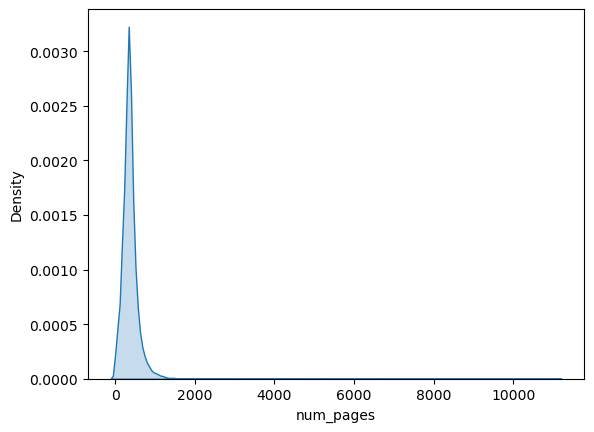

In [119]:
sns.kdeplot(books.num_pages, fill=True)

<Axes: xlabel='num_pages', ylabel='average_rating'>

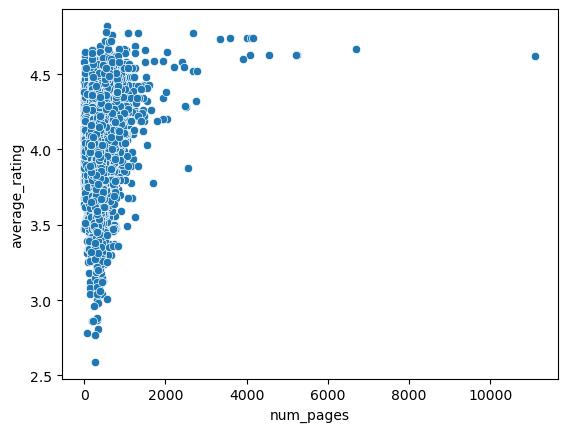

In [124]:
sns.scatterplot(x="num_pages", y="average_rating", data=books)

<Axes: xlabel='publication_date', ylabel='average_rating'>

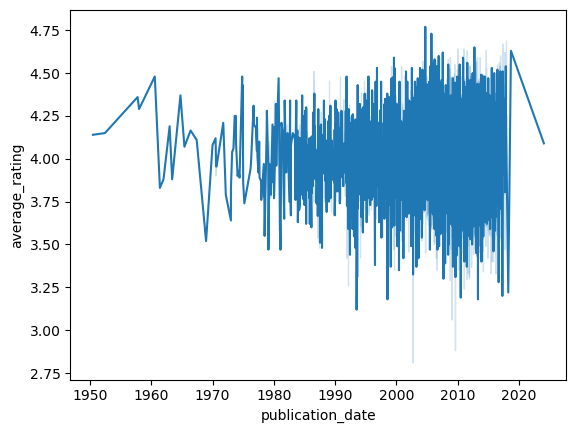

In [149]:
sns.lineplot(x="publication_date", y="average_rating", data=books)